# Initialization

Test notebook for the C-MAPPS benchmark. Approach using MLP. 

First we import the necessary packages and create the global variables.

In [52]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib
import seaborn as sns
import pandas as pd
import time

import CMAPSAuxFunctions
#import plottingTools
#from datetime import datetime
#from sklearn.covariance import EllipticEnvelope
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import train_test_split, cross_validate
#from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.mplot3d import Axes3D
#from dataManagement import DataManagerDamadics
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from IPython.display import display, HTML
%matplotlib notebook

num_epoch = 250
batch_size = 512

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
standardScaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# Retrieve and Reshape data

Get the data from the text files, store it in a Pandas Dataframe and reshape it as appropiately.

In [74]:
datasetNumber = '2'
data_file_train = '../CMAPSSData/train_FD00'+datasetNumber+'.txt'
data_file_test = '../CMAPSSData/test_FD00'+datasetNumber+'.txt'
rul_file = '../CMAPSSData/RUL_FD00'+datasetNumber+'.txt'

constRUL = 125
time_window = 30
window_stride = 1
rul_vector = None

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

nFeatures = len(selected_features)

#Get the X and y matrices with the specified time window
X_train, y_train, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, 
                                                                  time_window=time_window, dataset_type='train', 
                                                                  stride=window_stride)
X_test, _, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, 
                                                           time_window=time_window, dataset_type='test')

#Standardize the data
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

#Retrieve the data as Xiang

#X_train, y_train, min_max_scaler = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, 
#                                                               time_window, 'train', scaler=min_max_scaler)

#X_test, _ , _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, 
#                                                        time_window, 'test', scaler=min_max_scaler, fit_transform=False)

y_test = np.loadtxt(rul_file)
y_test = np.array([x if x < constRUL else constRUL for x in y_test])
y_test = np.reshape(y_test, (y_test.shape[0], 1))

In [75]:
print("Training data (X, y)")
print(X_train.shape)
print(y_train.shape)
print("Testing data (X, y)")
print(X_test.shape)
print(y_test.shape)

'''
print("Training data (samples, targets)")
print(samples.shape)
print(targets.shape)
print("Testing data (samples, targets)")
print(samplet.shape)
print(labelt.shape)
'''

print("Training data (X, y)")
print(X_train[:5,:])
print(y_train[:5,:])
print("Testing data (X, y)")
print(X_test[:5,:])
print(y_test[:5,:])

'''
print("Training data (samples, targets)")
print(samples[:5,:])
print(targets[:5])
print("Testing data (samples, targets)")
print(samplet[:5,:])
print(labelt[:5])

print("Training data (X, y)")
print(X_train[-5:,:])
print(y_train[-5:,:])
print("Testing data (X, y)")
print(X_test[-5:,:])
print(y_test[-5:,:])

print("Training data (samples, targets)")
print(samples[-5:,:])
print(targets[-5:])
print("Testing data (samples, targets)")
print(samplet[-5:,:])
print(labelt[-5:])
'''

Training data (X, y)
(17731, 420)
(17731, 1)
Testing data (X, y)
(100, 420)
(100, 1)
Training data (X, y)
[[-0.58075601 -0.0455243  -0.27982732 ... -0.81818182  0.43307087
   0.4679733 ]
 [-0.35395189  0.0629156  -0.18014129 ... -0.45454545  0.25984252
   0.25294702]
 [-0.21649485 -0.13299233 -0.13854003 ... -0.45454545  0.38582677
   0.72049425]
 [-0.21649485 -0.39897698 -0.2299843  ... -0.45454545  0.08661417
   0.29640676]
 [-0.20274914 -0.39590793 -0.05926217 ... -0.45454545  0.05511811
   0.17880983]]
[[125.]
 [125.]
 [125.]
 [125.]
 [125.]]
Testing data (X, y)
[[-0.65635739 -0.10946292 -0.48312402 ... -0.27272727  0.05511811
   0.30947309]
 [ 0.03780069 -0.07365729 -0.27629513 ... -0.63636364  0.05511811
   0.04416986]
 [ 0.13402062 -0.08644501  0.038854   ...  0.09090909  0.24409449
   0.07882403]
 [-0.14776632  0.16828645  0.00431711 ...  0.09090909 -0.30708661
   0.03365999]
 [-0.05841924  0.24654731  0.04317111 ... -0.09090909 -0.03937008
   0.46996165]]
[[112.]
 [ 98.]
 [ 69

'\nprint("Training data (samples, targets)")\nprint(samples[:5,:])\nprint(targets[:5])\nprint("Testing data (samples, targets)")\nprint(samplet[:5,:])\nprint(labelt[:5])\n\nprint("Training data (X, y)")\nprint(X_train[-5:,:])\nprint(y_train[-5:,:])\nprint("Testing data (X, y)")\nprint(X_test[-5:,:])\nprint(y_test[-5:,:])\n\nprint("Training data (samples, targets)")\nprint(samples[-5:,:])\nprint(targets[-5:])\nprint("Testing data (samples, targets)")\nprint(samplet[-5:,:])\nprint(labelt[-5:])\n'

# Keras model

We will use a very simple ANN for this example. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [76]:
def RULmodel_SN_1(input_shape):
    
    print(input_shape)
    
    #Create a sequential model
    model = Sequential()
    
    #Add the layers for the model
    model.add(Dense(250, input_dim=input_shape, activation='relu', kernel_initializer='glorot_normal', name='fc1'))
    model.add(Dropout(0.6))
    model.add(Dense(50, activation='relu', kernel_initializer='glorot_normal', name='fc2'))
    #model.add(Dense(5, activation='relu', kernel_initializer='glorot_normal', name='fc3'))
    model.add(Dropout(0.2))
    #model.add(Dense(10, activation='relu', name='fc3'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='tanh', name='fc4'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', name='out'))
    
    #create a placeholder for the input
    #X_input = Input(shape=(input_shape))
    
    #Create the layers
    #X = Dense(100, activation='relu', name='fc1')(X_input)
    #X = Dense(100, activation='relu', name='fc2')(X)
    #X = Dense(1, activation='linear', name='out')(X)
    
    # Create model. This creates the Keras model instance, you'll use this instance to train/test the model.
    #model = Sequential(inputs = X_input, outputs = X, name='RUL')
    
    return model


def RULModel_CNN_1(input_shape):
    
    #Create a sequential model
    model = Sequential()
    
    print(input_shape)
    
    #Add the layers for the model
    model.add(Conv2D(1, (10,10), input_shape=input_shape, padding='same', kernel_initializer='glorot_normal', activation='relu', name='cl1'))
    model.add(Dropout(0.6))
    model.add(MaxPooling2D(pool_size=5, name='pl1'))
    model.add(Flatten())
    model.add(Dense(20, activation='relu', kernel_initializer='glorot_normal', name='fc1'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear', name='out'))
    
    return model


def RULCNNModel(TW, FeatureN):
    
    input_layer = Input(shape=(TW, FeatureN))
    y = Reshape((TW, FeatureN, 1), input_shape=(TW, FeatureN, ),name = 'Reshape')(input_layer)

    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C1')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C2')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C3')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C4')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C5')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C6')(y)
    
    y = Conv2D(1, 3, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='Clast')(y)  
    
    y = Reshape((TW,14))(y)
    y = Flatten()(y)
    y = Dropout(0.5)(y)
    
    #y = Dense(100, activation='tanh', init='glorot_normal', activity_regularizer=keras.regularizers.l2(0.01),)(y)
    y = Dense(100,activation='tanh', kernel_initializer='glorot_normal', name='fc')(y)
    y = Dense(1)(y)
    
    model = Model(inputs = input_layer, outputs = y, name='RUL_CNN_Model')
    
    return model

# Fit the keras model
Fit the Keras model to the data and determine its performance.

In [77]:
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)
opt = Adam(lr=0, beta_1=0.5)

#Create the model
modelRULSN = RULmodel_SN_1(X_train.shape[1])

#Compile the model.
modelRULSN.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])

startTime = time.clock()
#Train the model.
modelRULSN.fit(x = X_train, y = y_train, epochs = num_epoch, batch_size = batch_size, callbacks=[lrate])  
endTime = time.clock()

420
Epoch 1/250
17731/17731 [==============================] - 0s 17us/step - loss: 3458.9188 - mean_squared_error: 3458.9188
Epoch 2/250
17731/17731 [==============================] - 0s 12us/step - loss: 587.5341 - mean_squared_error: 587.5341
Epoch 3/250
17731/17731 [==============================] - 0s 10us/step - loss: 457.7061 - mean_squared_error: 457.7061
Epoch 4/250
17731/17731 [==============================] - 0s 14us/step - loss: 403.3933 - mean_squared_error: 403.3933
Epoch 5/250
17731/17731 [==============================] - 0s 14us/step - loss: 377.4075 - mean_squared_error: 377.4075
Epoch 6/250
17731/17731 [==============================] - 0s 11us/step - loss: 352.5351 - mean_squared_error: 352.5351
Epoch 7/250
17731/17731 [==============================] - 0s 9us/step - loss: 350.0426 - mean_squared_error: 350.0426
Epoch 8/250
17731/17731 [==============================] - 0s 11us/step - loss: 339.4991 - mean_squared_error: 339.4991
Epoch 9/250
17731/17731 [==========

17731/17731 [==============================] - 0s 12us/step - loss: 277.2218 - mean_squared_error: 277.2218
Epoch 69/250
17731/17731 [==============================] - 0s 13us/step - loss: 269.9711 - mean_squared_error: 269.9711
Epoch 70/250
17731/17731 [==============================] - 0s 13us/step - loss: 274.3298 - mean_squared_error: 274.3298
Epoch 71/250
17731/17731 [==============================] - 0s 12us/step - loss: 276.1753 - mean_squared_error: 276.1753
Epoch 72/250
17731/17731 [==============================] - 0s 11us/step - loss: 271.4750 - mean_squared_error: 271.4750
Epoch 73/250
17731/17731 [==============================] - 0s 11us/step - loss: 274.3129 - mean_squared_error: 274.3129
Epoch 74/250
17731/17731 [==============================] - 0s 10us/step - loss: 268.5180 - mean_squared_error: 268.5180
Epoch 75/250
17731/17731 [==============================] - 0s 13us/step - loss: 269.0841 - mean_squared_error: 269.0841
Epoch 76/250
17731/17731 [===================

17731/17731 [==============================] - 0s 12us/step - loss: 242.5287 - mean_squared_error: 242.5287
Epoch 136/250
17731/17731 [==============================] - 0s 13us/step - loss: 244.4048 - mean_squared_error: 244.4048
Epoch 137/250
17731/17731 [==============================] - 0s 10us/step - loss: 236.6123 - mean_squared_error: 236.6123
Epoch 138/250
17731/17731 [==============================] - 0s 12us/step - loss: 235.6505 - mean_squared_error: 235.6505
Epoch 139/250
17731/17731 [==============================] - 0s 11us/step - loss: 234.8381 - mean_squared_error: 234.8381
Epoch 140/250
17731/17731 [==============================] - 0s 15us/step - loss: 238.2225 - mean_squared_error: 238.2225
Epoch 141/250
17731/17731 [==============================] - 0s 11us/step - loss: 237.6370 - mean_squared_error: 237.6370
Epoch 142/250
17731/17731 [==============================] - 0s 12us/step - loss: 237.9816 - mean_squared_error: 237.9816
Epoch 143/250
17731/17731 [===========

17731/17731 [==============================] - 0s 15us/step - loss: 204.6375 - mean_squared_error: 204.6375
Epoch 203/250
17731/17731 [==============================] - 0s 12us/step - loss: 205.8171 - mean_squared_error: 205.8171
Epoch 204/250
17731/17731 [==============================] - 0s 11us/step - loss: 200.9953 - mean_squared_error: 200.9953
Epoch 205/250
17731/17731 [==============================] - 0s 12us/step - loss: 208.9498 - mean_squared_error: 208.9498
Epoch 206/250
17731/17731 [==============================] - 0s 12us/step - loss: 203.2750 - mean_squared_error: 203.2750
Epoch 207/250
17731/17731 [==============================] - 0s 14us/step - loss: 205.2272 - mean_squared_error: 205.2272
Epoch 208/250
17731/17731 [==============================] - 0s 11us/step - loss: 204.0467 - mean_squared_error: 204.0467
Epoch 209/250
17731/17731 [==============================] - 0s 11us/step - loss: 205.6998 - mean_squared_error: 205.6998
Epoch 210/250
17731/17731 [===========

In [78]:
#Evaluate the model
score = modelRULSN.evaluate(x = X_test, y = y_test)
y_pred = modelRULSN.predict(X_test)
healtScore = CMAPSAuxFunctions.compute_health_score(y_test, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score[0])))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 1ms/step
Root Square Mean Error score: 13.994209781537075
Health score: [380.00891563]
Elapsed time: 52.370210882918855


# CNN Model
Fit the Keras model to the data using a CNN and determine its performance.

# Initialization

In [79]:
#Create samples and labels matrices to be used with the CNN
X_train_CNN = np.reshape(X_train, newshape=(X_train.shape[0], time_window, int(X_train.shape[1]/time_window), 1))
X_test_CNN = np.reshape(X_test, newshape=(X_test.shape[0], time_window, int(X_test.shape[1]/time_window), 1))
y_train_CNN = np.reshape(y_train, newshape=(y_train.shape[0], -1))
y_test_CNN = np.reshape(y_test, newshape=(y_test.shape[0], -1))

print("Training data (X, y)")
print(X_train_CNN.shape)
print(y_train_CNN.shape)
print("Testing data (X, y)")
print(X_test_CNN.shape)
print(y_test_CNN.shape)

Training data (X, y)
(17731, 30, 14, 1)
(17731, 1)
Testing data (X, y)
(100, 30, 14, 1)
(100, 1)


# Constants

In [80]:
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)
opt = Adam(lr=0, beta_1=0.5)

#Create the model
modelRULCNN = RULModel_CNN_1(X_train_CNN.shape[1:4])

#Compile the model.
modelRULCNN.compile(optimizer = opt, loss = "mean_squared_error", metrics = ["mse"])

startTime = time.clock()
#Train the model.
modelRULCNN.fit(x = X_train_CNN, y = y_train_CNN, epochs = num_epoch, batch_size = batch_size, callbacks=[lrate])  
endTime = time.clock()

(30, 14, 1)
Epoch 1/250
17731/17731 [==============================] - 0s 22us/step - loss: 8304.9094 - mean_squared_error: 8304.9094
Epoch 2/250
17731/17731 [==============================] - 0s 16us/step - loss: 8106.3643 - mean_squared_error: 8106.3643
Epoch 3/250
17731/17731 [==============================] - 0s 16us/step - loss: 6233.9318 - mean_squared_error: 6233.9318
Epoch 4/250
17731/17731 [==============================] - 0s 18us/step - loss: 2335.2967 - mean_squared_error: 2335.2967
Epoch 5/250
17731/17731 [==============================] - 0s 23us/step - loss: 1314.9545 - mean_squared_error: 1314.9545
Epoch 6/250
17731/17731 [==============================] - 0s 16us/step - loss: 1121.0219 - mean_squared_error: 1121.0219
Epoch 7/250
17731/17731 [==============================] - 0s 19us/step - loss: 1002.9409 - mean_squared_error: 1002.9409
Epoch 8/250
17731/17731 [==============================] - 0s 16us/step - loss: 891.3052 - mean_squared_error: 891.3052
Epoch 9/250
17

17731/17731 [==============================] - 0s 17us/step - loss: 654.6407 - mean_squared_error: 654.6407
Epoch 69/250
17731/17731 [==============================] - 0s 17us/step - loss: 632.5032 - mean_squared_error: 632.5032
Epoch 70/250
17731/17731 [==============================] - 0s 18us/step - loss: 640.1932 - mean_squared_error: 640.1932
Epoch 71/250
17731/17731 [==============================] - 0s 18us/step - loss: 648.6715 - mean_squared_error: 648.6715
Epoch 72/250
17731/17731 [==============================] - 0s 16us/step - loss: 629.8749 - mean_squared_error: 629.8749
Epoch 73/250
17731/17731 [==============================] - 0s 14us/step - loss: 625.9886 - mean_squared_error: 625.9886
Epoch 74/250
17731/17731 [==============================] - 0s 19us/step - loss: 620.6127 - mean_squared_error: 620.6127
Epoch 75/250
17731/17731 [==============================] - 0s 17us/step - loss: 616.8368 - mean_squared_error: 616.8368
Epoch 76/250
17731/17731 [===================

17731/17731 [==============================] - 0s 16us/step - loss: 567.4197 - mean_squared_error: 567.4197
Epoch 136/250
17731/17731 [==============================] - 0s 17us/step - loss: 576.5158 - mean_squared_error: 576.5158
Epoch 137/250
17731/17731 [==============================] - 0s 17us/step - loss: 576.0065 - mean_squared_error: 576.0065
Epoch 138/250
17731/17731 [==============================] - 0s 17us/step - loss: 579.7688 - mean_squared_error: 579.7688
Epoch 139/250
17731/17731 [==============================] - 0s 19us/step - loss: 569.5436 - mean_squared_error: 569.5436
Epoch 140/250
17731/17731 [==============================] - 0s 19us/step - loss: 563.4355 - mean_squared_error: 563.4355
Epoch 141/250
17731/17731 [==============================] - 0s 16us/step - loss: 568.0769 - mean_squared_error: 568.0769
Epoch 142/250
17731/17731 [==============================] - 0s 16us/step - loss: 564.0686 - mean_squared_error: 564.0686
Epoch 143/250
17731/17731 [===========

17731/17731 [==============================] - 0s 17us/step - loss: 551.8887 - mean_squared_error: 551.8887
Epoch 203/250
17731/17731 [==============================] - 0s 17us/step - loss: 562.4354 - mean_squared_error: 562.4354
Epoch 204/250
17731/17731 [==============================] - 0s 16us/step - loss: 569.6359 - mean_squared_error: 569.6359
Epoch 205/250
17731/17731 [==============================] - 0s 16us/step - loss: 553.4175 - mean_squared_error: 553.4175
Epoch 206/250
17731/17731 [==============================] - 0s 18us/step - loss: 553.3413 - mean_squared_error: 553.3413
Epoch 207/250
17731/17731 [==============================] - 0s 18us/step - loss: 551.1878 - mean_squared_error: 551.1878
Epoch 208/250
17731/17731 [==============================] - 0s 15us/step - loss: 555.9353 - mean_squared_error: 555.9353
Epoch 209/250
17731/17731 [==============================] - 0s 18us/step - loss: 564.6765 - mean_squared_error: 564.6765
Epoch 210/250
17731/17731 [===========

# Reshape data to fit a convNet

In [81]:
#Evaluate the model
score = modelRULCNN.evaluate(x = X_test_CNN, y = y_test_CNN)
y_pred = modelRULCNN.predict(X_test_CNN)
healtScore = CMAPSAuxFunctions.compute_health_score(y_test_CNN, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score[0])))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 2ms/step
Root Square Mean Error score: 48.95228234991322
Health score: [10890.4241548]
Elapsed time: 74.66642293856148


# Keras model

CNN model. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [82]:

FilterN = 10
FilterL = 10
rmse,sco,tm = [], [], []

# Fit the keras model

Fit the Keras model to the data and determine its performance.

In [83]:
#Create samples and labels matrices to be used with the CNN
samples = np.reshape(X_train, newshape=(X_train.shape[0], time_window, int(X_train.shape[1]/time_window)))
samplet = np.reshape(X_test, newshape=(X_test.shape[0], time_window, int(X_test.shape[1]/time_window)))
targets = np.reshape(y_train, newshape=(y_train.shape[0], -1))
labelt = np.reshape(y_test, newshape=(y_test.shape[0], -1))

print("Training data (samples, targets)")
print(samples.shape)
print(targets.shape)
print("Testing data (samples, targets)")
print(samplet.shape)
print(labelt.shape)

Training data (samples, targets)
(17731, 30, 14)
(17731, 1)
Testing data (samples, targets)
(100, 30, 14)
(100, 1)


In [84]:
opt = Adam(lr=0, beta_1=0.5)
#DCNN = Model([input_layer], [y])
DCNN = RULCNNModel(time_window, samples.shape[2])
#DCNN.compile(loss=get_score,optimizer=opt)
DCNN.compile(loss='mean_squared_error',optimizer=opt)
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)


startTime = time.clock()
history = DCNN.fit(samples, targets,nb_epoch=num_epoch, batch_size=batch_size,verbose=1, 
                   validation_data=(samplet, labelt), callbacks=[lrate])
endTime = time.clock()

C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), activation="tanh", padding="same", name="C1", kernel_initializer="glorot_normal")`
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), activation="tanh", padding="same", name="C2", kernel_initializer="glorot_normal")`
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), activation="tanh", padding="same", name="C3", kernel_initializer="glorot_normal")`
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), activation="tanh", padding="same", name="C4", kernel_initializer="g

Train on 17731 samples, validate on 100 samples
Epoch 1/250
17731/17731 [==============================] - 1s 35us/step - loss: 6570.3175 - val_loss: 4956.9717
Epoch 2/250
17731/17731 [==============================] - 0s 22us/step - loss: 5612.5131 - val_loss: 4527.0615
Epoch 3/250
17731/17731 [==============================] - 0s 22us/step - loss: 5163.1046 - val_loss: 4152.4185
Epoch 4/250
17731/17731 [==============================] - 0s 22us/step - loss: 4761.3240 - val_loss: 3815.9534
Epoch 5/250
17731/17731 [==============================] - 0s 22us/step - loss: 4393.9737 - val_loss: 3499.9233
Epoch 6/250
17731/17731 [==============================] - 0s 22us/step - loss: 4055.7912 - val_loss: 3209.5715
Epoch 7/250
17731/17731 [==============================] - 0s 22us/step - loss: 3744.1688 - val_loss: 2946.0232
Epoch 8/250
17731/17731 [==============================] - 0s 22us/step - loss: 3455.9065 - val_loss: 2702.8643
Epoch 9/250
17731/17731 [==============================]

17731/17731 [==============================] - 0s 22us/step - loss: 171.6730 - val_loss: 164.1549
Epoch 75/250
17731/17731 [==============================] - 0s 22us/step - loss: 173.4664 - val_loss: 181.6556
Epoch 76/250
17731/17731 [==============================] - 0s 22us/step - loss: 173.2070 - val_loss: 165.4126
Epoch 77/250
17731/17731 [==============================] - 0s 22us/step - loss: 168.1417 - val_loss: 186.9861
Epoch 78/250
17731/17731 [==============================] - 0s 22us/step - loss: 170.5662 - val_loss: 153.1297
Epoch 79/250
17731/17731 [==============================] - 0s 22us/step - loss: 168.9160 - val_loss: 158.6647
Epoch 80/250
17731/17731 [==============================] - 0s 22us/step - loss: 171.6488 - val_loss: 156.8222
Epoch 81/250
17731/17731 [==============================] - 0s 22us/step - loss: 166.9820 - val_loss: 174.5399
Epoch 82/250
17731/17731 [==============================] - 0s 22us/step - loss: 167.4735 - val_loss: 172.1002
Epoch 83/250
1

17731/17731 [==============================] - 0s 22us/step - loss: 143.5147 - val_loss: 176.6555
Epoch 148/250
17731/17731 [==============================] - 0s 22us/step - loss: 136.3781 - val_loss: 150.1977
Epoch 149/250
17731/17731 [==============================] - 0s 22us/step - loss: 140.8428 - val_loss: 140.9213
Epoch 150/250
17731/17731 [==============================] - 0s 22us/step - loss: 140.2049 - val_loss: 155.1263
Epoch 151/250
17731/17731 [==============================] - 0s 22us/step - loss: 137.2569 - val_loss: 161.6683
Epoch 152/250
17731/17731 [==============================] - 0s 23us/step - loss: 139.7008 - val_loss: 174.4596
Epoch 153/250
17731/17731 [==============================] - 0s 22us/step - loss: 136.4772 - val_loss: 168.9162
Epoch 154/250
17731/17731 [==============================] - 0s 22us/step - loss: 137.4117 - val_loss: 178.7894
Epoch 155/250
17731/17731 [==============================] - 0s 22us/step - loss: 133.4712 - val_loss: 168.7793
Epoch 

17731/17731 [==============================] - 0s 22us/step - loss: 118.6338 - val_loss: 154.0859
Epoch 221/250
17731/17731 [==============================] - 0s 22us/step - loss: 118.6004 - val_loss: 151.0843
Epoch 222/250
17731/17731 [==============================] - 0s 22us/step - loss: 118.8172 - val_loss: 151.2820
Epoch 223/250
17731/17731 [==============================] - 0s 22us/step - loss: 118.8599 - val_loss: 151.4362
Epoch 224/250
17731/17731 [==============================] - 0s 22us/step - loss: 119.3789 - val_loss: 152.9864
Epoch 225/250
17731/17731 [==============================] - 0s 22us/step - loss: 119.2478 - val_loss: 151.2462
Epoch 226/250
17731/17731 [==============================] - 0s 22us/step - loss: 119.8695 - val_loss: 150.5450
Epoch 227/250
17731/17731 [==============================] - 0s 22us/step - loss: 118.6724 - val_loss: 156.1495
Epoch 228/250
17731/17731 [==============================] - 0s 22us/step - loss: 121.1523 - val_loss: 151.7752
Epoch 

In [85]:
#Evaluate the model
score = DCNN.evaluate(samplet, labelt)
y_pred = DCNN.predict(samplet)
healtScore = CMAPSAuxFunctions.compute_health_score(labelt, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score)))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 90us/step
Root Square Mean Error score: 12.271248387483023
Health score: [269.17812267]
Elapsed time: 98.7174685760192


In [86]:
def plotRUL(cycles, rulArray, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    
    plt.show()

<IPython.core.display.Javascript object>


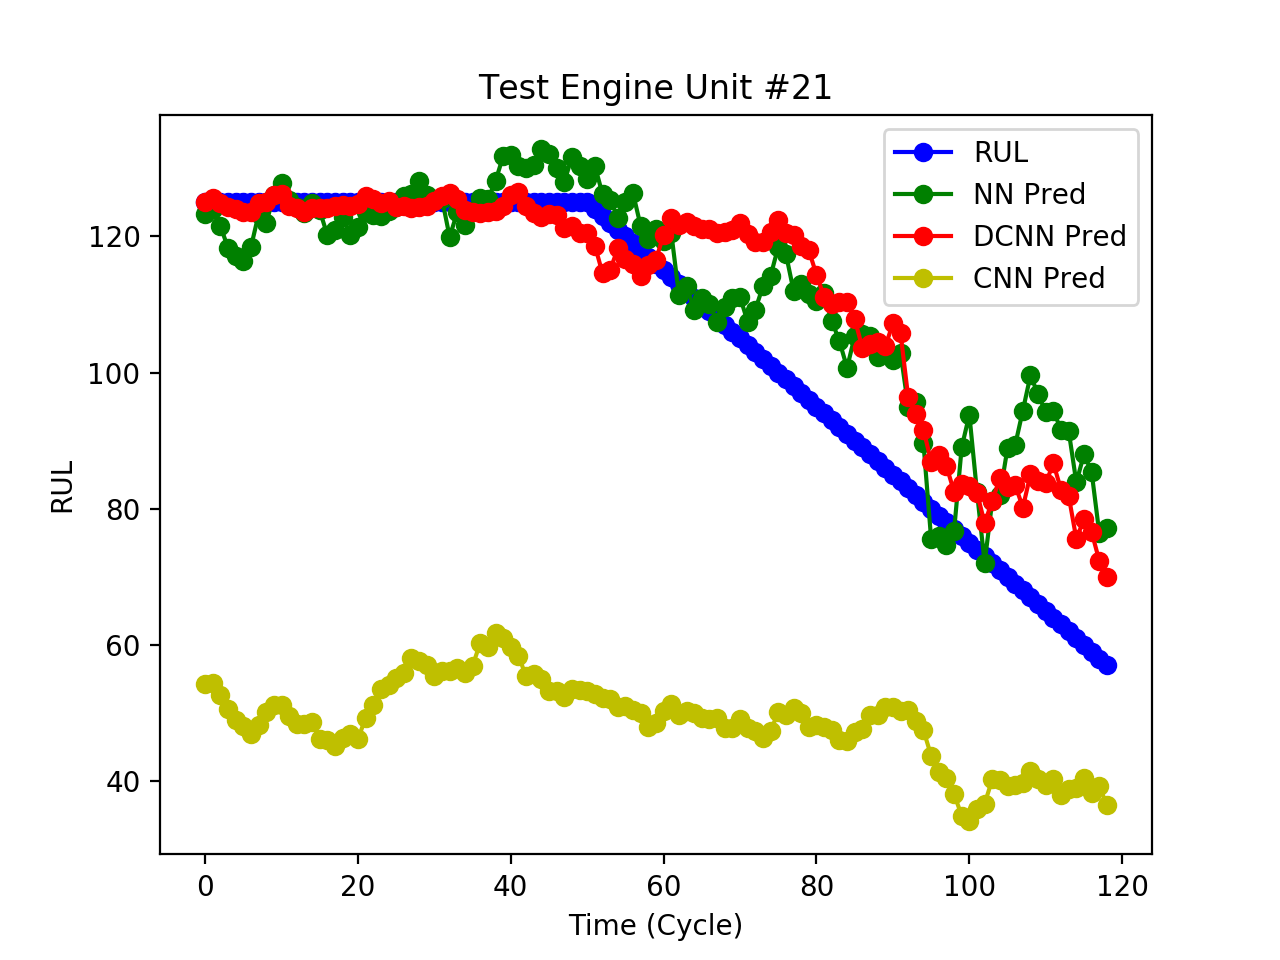

In [87]:
engineUnit = 21

#X_test2, _, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 
#                                                             'train', scaler=min_max_scaler, fit_transform=False, unit_number=engineUnit)

X_test2, _, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, 
                                                                  time_window=time_window, dataset_type='train', 
                                                                  stride=1, unit_number=engineUnit)


#X_test2, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'train', unit_number=engineUnit)
X_test2 = min_max_scaler.transform(X_test2)

samplet2 = np.reshape(X_test2, newshape=(X_test2.shape[0], int(X_test2.shape[1]/nFeatures), nFeatures))

X_test2_CNN = np.reshape(X_test2, newshape=(X_test2.shape[0], time_window, int(X_test2.shape[1]/time_window), 1))

nnPred = modelRULSN.predict(X_test2)
dcnnPred = DCNN.predict(samplet2)
cnnPred = modelRULCNN.predict(X_test2_CNN)

maxCycle = X_test2.shape[0]
faultCycle = y_test[engineUnit-1]
cycles = np.arange(maxCycle)
rulArray = np.arange(faultCycle, maxCycle+faultCycle)
rulArray[rulArray > constRUL] = constRUL
rulArray = np.flipud(rulArray)

'''print("Testing data")
print(X_test2.shape)
print(X_test2[-5:,:])
print(nnPred)
print(cnnPred)'''

plotRUL(cycles, rulArray, engineUnit)
plt.plot(cycles, nnPred, 'go-', label='NN Pred')
plt.plot(cycles, dcnnPred, 'ro-', label='DCNN Pred')
plt.plot(cycles, cnnPred, 'yo-', label='CNN Pred')

plt.legend()

